In [1]:
from time import perf_counter
import os
from joblib import Parallel, delayed
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()
SAVE = False
SAVE_CSV = False
DECIMATE = 10
PATH = './results/iters/iters'

np.random.seed(SEED)

In [2]:
def run_experiment(g, Exps, graph_p, signal_p, def_args, verb=True):
    Adj_list = utils.create_dinamic_graph(**graph_p)
    X_list, _ = utils.create_dinamic_gmrf_signals(Adj_list, **signal_p)
    n_nodes = Adj_list[-1].shape[0]
    n_samples = np.array( [X_i.shape[1] for X_i in X_list] ).sum()

    Adjs_off = None
    err_seq = np.zeros((n_samples, len(Exps)))
    runtime = np.zeros(len(Exps))
    err_wrt_off = np.zeros((n_samples, len(Exps)))
    regret = np.zeros((n_samples, len(Exps)))
    for i, exp in enumerate(Exps):
        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        args_aux['lamb'] = utils.lamb_value(n_nodes, n_samples, args_aux['lamb'])
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, **args_aux)
        t_end = perf_counter()

        if i == 0:
            Adjs_off = model.S_seq.copy()

        err_seq[:,i] = model.test_sequence_err(Adj_list)
        runtime[i] = t_end - t_init
        err_wrt_off[:,i], regret[:,i] = model.regret(Adjs_off)
        err_graph_aux = model.test_err(Adj_list)

        if verb and g % N_CPUS == 0:
            print(f'- {g+1}. {exp["leg"]}: Err last graph: {err_graph_aux[-1]:.3f}  -  Err last graph off: {err_wrt_off[-1,i]:.3f}  ' +\
                  f'-   time: {runtime[i]:.3f} secs')            
    
    return err_seq, runtime, err_wrt_off, regret


# Iters vs Node freq

In [3]:
# Default experiment parameters and auxiliary funcitons
## Graph parameters
n_graphs = 50
N = 50  # 50
verb = True
COLD_START = False
OFFLINE_ITERS = 100
OFF_UPDATE = 'incr'

graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_edges': 4,
    'load_adjs_fact': .1,  # 01
    'conn_nodes': True,
}

signal_p = {
    'noise_power': .05,
}

default_args = {
    'iters_sample': 1,
    'lamb': .5, #1e-2,
    'stepsize': 1e-3,
    'gamma':  .99,
    'epsilon': 1,
    'alpha': 0,
}

In [4]:
###  Low frequency   ###
graph_p['new_nodes'] = [20]
signal_p['samples_t'] = [1000] + [1500]

Exps_low = [
    # Offline as a baseline!
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'leg': 'Off-Low', 'fmt': '-',
     'args': {'iters_sample': OFFLINE_ITERS, 'cold_start': COLD_START}},

    # Online and batch
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 1}, 'leg': f'1-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 5}, 'leg': f'5-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 10}, 'leg': f'10-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 25}, 'leg': f'25-Low', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 50}, 'leg': f'50-Low', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps_low, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_seq_low, runtime_low, err_off_low, regret_low = zip(*results)

CPUs employed: 64
- 1. Off-Low: Err last graph: 0.081  -  Err last graph off: 0.000  -   time: 150.732 secs
- 1. 1-Low: Err last graph: 0.100  -  Err last graph off: 0.119  -   time: 1.523 secs
- 1. 5-Low: Err last graph: 0.051  -  Err last graph off: 0.061  -   time: 7.068 secs
- 1. 10-Low: Err last graph: 0.041  -  Err last graph off: 0.042  -   time: 19.514 secs
- 1. 25-Low: Err last graph: 0.044  -  Err last graph off: 0.020  -   time: 51.907 secs
- 1. 50-Low: Err last graph: 0.059  -  Err last graph off: 0.006  -   time: 103.078 secs
----- Solved in 6.274 minutes -----


In [5]:
# ### LOAD DATA ###
# file_name = './results/iters/iters_low_errs.npz'
# data = np.load(file_name, allow_pickle=True)
# err_seq_low = data['err_seq'] 
# err_off_low = data['err_off'] 
# regret_low = data['regret'] 
# runtime_low = data['runtime']
# Exps_low = data['Exps']

In [6]:
if SAVE:
    err_dict = {'err_seq': err_seq_low, 'runtime': runtime_low, 'err_off': err_off_low,
                'regret': regret_low}
    file_name = PATH + f'_low'
    utils.save_data(file_name, Exps_low, err_dict, agg='median', save_csv=SAVE_CSV, dec=DECIMATE)

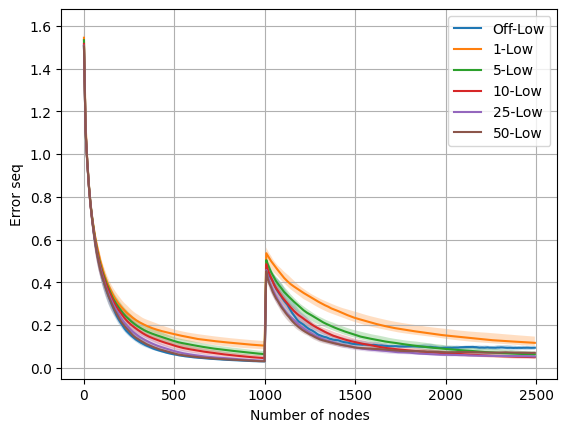

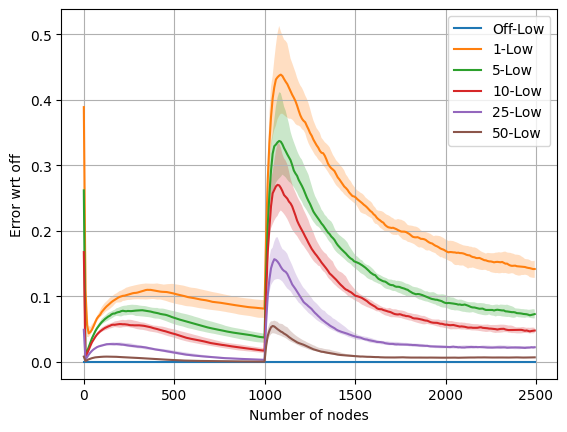

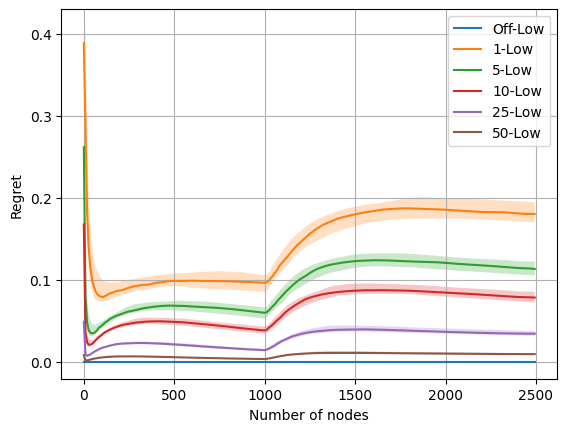

In [7]:
fig, axes = plt.subplots()
utils.plot_data(axes, err_seq_low, Exps_low, np.arange(err_seq_low[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='median', deviation='prctile', dec=DECIMATE)

fig, axes = plt.subplots()
utils.plot_data(axes, err_off_low, Exps_low, np.arange(err_off_low[0].shape[0]), 'Number of nodes', 'Error wrt off',
                    agg='median', deviation='prctile', dec=DECIMATE)
fig, axes = plt.subplots()
utils.plot_data(axes, regret_low, Exps_low, np.arange(regret_low[0].shape[0]), 'Number of nodes', 'Regret',
                    agg='median', deviation='prctile', dec=DECIMATE)

In [8]:
###  High frequency   ###
graph_p['new_nodes'] = [5]*4
signal_p['samples_t'] = [400]*4 + [900]

Exps_high = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'leg': 'Off-High', 'fmt': '-',
     'args': {'iters_sample': OFFLINE_ITERS, 'cold_start': COLD_START}},

    # Online and batch
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 1}, 'leg': f'1-High', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 5}, 'leg': f'5-High', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 10}, 'leg': f'10-High', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 25}, 'leg': f'25-High', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'args': {'iters_sample': 50}, 'leg': f'50-High', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps_high, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_seq_high, runtime_high, err_off_high, regret_high = zip(*results)

CPUs employed: 64
- 1. Off-High: Err last graph: 0.112  -  Err last graph off: 0.000  -   time: 192.172 secs
- 1. 1-High: Err last graph: 0.158  -  Err last graph off: 0.184  -   time: 1.634 secs
- 1. 5-High: Err last graph: 0.081  -  Err last graph off: 0.102  -   time: 9.309 secs
- 1. 10-High: Err last graph: 0.059  -  Err last graph off: 0.069  -   time: 19.201 secs
- 1. 25-High: Err last graph: 0.056  -  Err last graph off: 0.032  -   time: 45.165 secs
- 1. 50-High: Err last graph: 0.078  -  Err last graph off: 0.010  -   time: 84.830 secs
----- Solved in 6.301 minutes -----


In [9]:
## LOAD DATA ###
# file_name = './results/iters/iters_high_errs.npz'
# data = np.load(file_name, allow_pickle=True)
# err_seq_high = data['err_seq'] 
# err_off_high = data['err_off'] 
# regret_high = data['regret'] 
# runtime_high = data['runtime']
# Exps_high = data['Exps']

In [10]:
### SAVE DATA ###
if SAVE:
    err_dict = {'err_seq': err_seq_high, 'runtime': runtime_high, 'err_off': err_off_high,
                'regret': regret_high}
    file_name = PATH + f'_high'
    utils.save_data(file_name, Exps_high, err_dict, agg='median', save_csv=SAVE_CSV,
                    dec=DECIMATE)

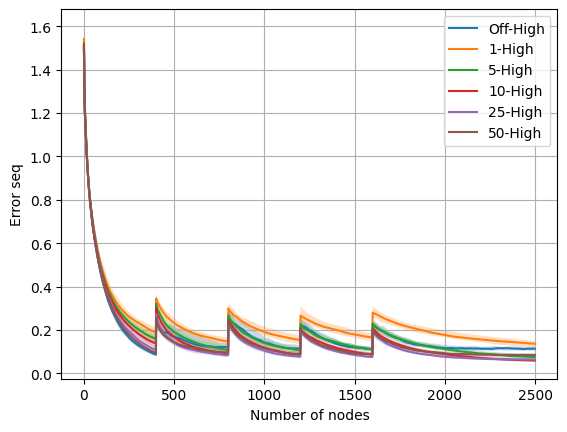

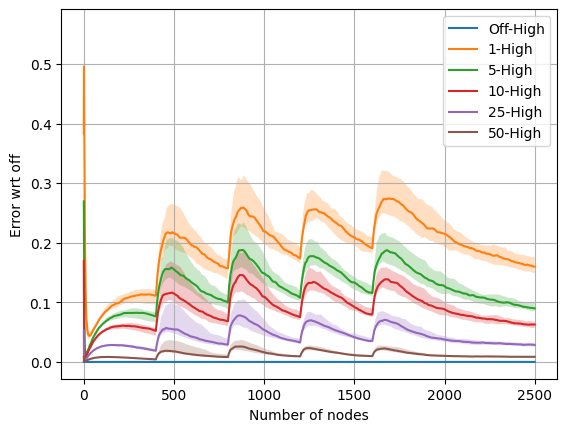

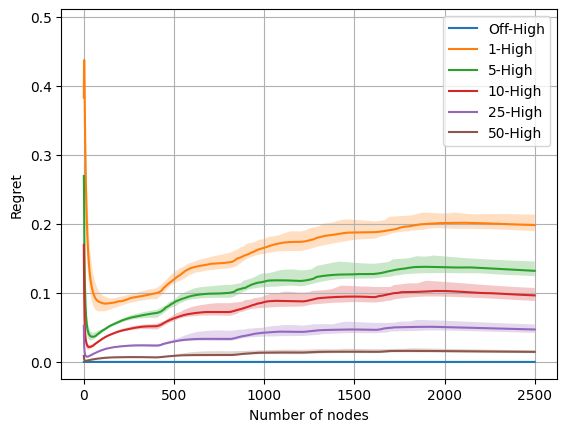

In [11]:
fig, axes = plt.subplots()
utils.plot_data(axes, err_seq_high, Exps_high, np.arange(err_seq_high[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='median', deviation='prctile')

fig, axes = plt.subplots()
utils.plot_data(axes, err_off_high, Exps_high, np.arange(err_off_high[0].shape[0]), 'Number of nodes', 'Error wrt off',
                    agg='median', deviation='prctile')
fig, axes = plt.subplots()
utils.plot_data(axes, regret_high, Exps_high, np.arange(regret_high[0].shape[0]), 'Number of nodes', 'Regret',
                    agg='median', deviation='prctile')